In [8]:
import simulator as sim
import generator as gen
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as c

hbar = c.hbar
muB = c.value('Bohr magneton')

# Bloch sphere states
up = np.array([[1], [0]], dtype=complex)
down = np.array([[0], [1]], dtype=complex)
plus_i = 1/np.sqrt(2) * np.array([[1], [1.0j]], dtype=complex)
minus_i = 1/np.sqrt(2) * np.array([[1], [-1.0j]], dtype=complex)

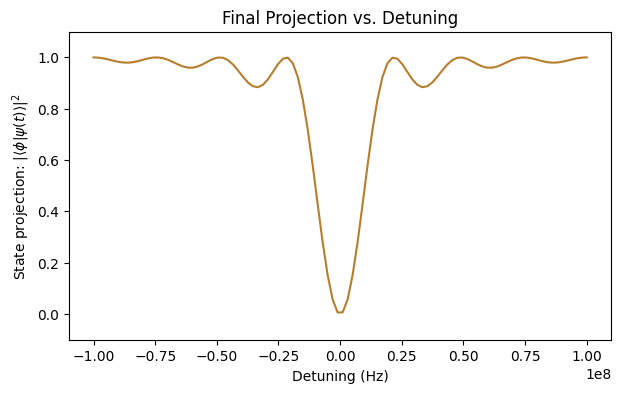

In [3]:
b1 = 0.001
g = 1.8
f_rabi = sim.predictRabi(b1, g) 
tau = 1/f_rabi * 0.5

# Time series simulations
# sim.simulateBlochSphere(up, b1, g, tau, det=0)
# sim.simulatePolarisations(up, b1, g, tau, det=0)
# sim.simulateProjection(minus, up, b1, g, tau, det=0)
plt.show()

# Simulations vs. detuning
detunings = np.linspace(-100e6, 100e6, 500)
# sim.polarisationSpectrum(up, b1, g, tau, detunings)
sim.projectionSpectrum(up, b1, g, tau, detunings, up)
# sim.timeRabiSpectrum(up, b1, g, tau*10, detunings)
# sim.powerRabiSpectrum(up, b1, g, tau, )
plt.show()

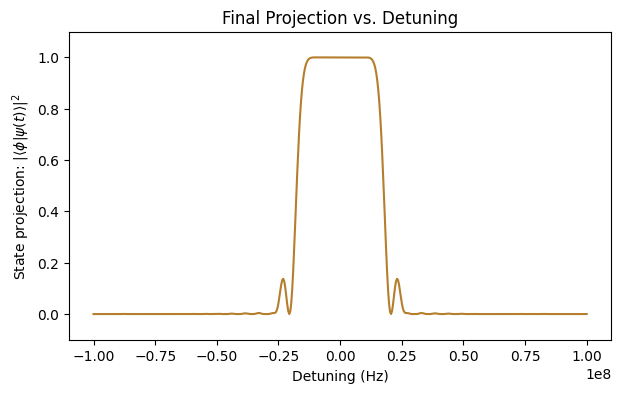

In [15]:
w1 = np.genfromtxt('Xpi2_200.csv', delimiter=',')
tau = 400e-9
gamma = g*muB/hbar
b1 = 2*w1/gamma
b1 = np.concatenate([b1, b1])

detunings = np.linspace(-100e6, 100e6, 500)
sim.projectionSpectrum(up, b1, g, tau, detunings, down)
plt.show()

Max rabi = 77.871MHz
Min Pi/2 time = 3.21ns
b1 amp = 0.006T


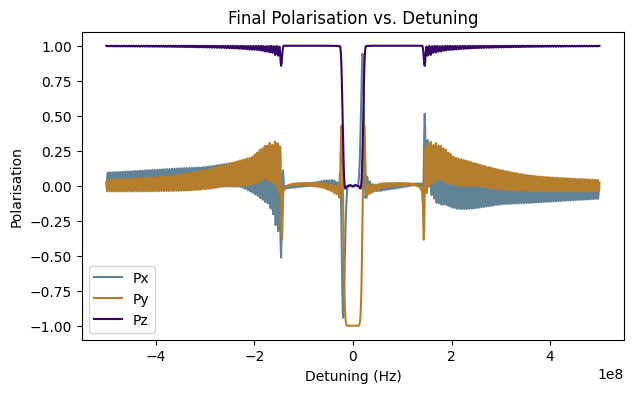

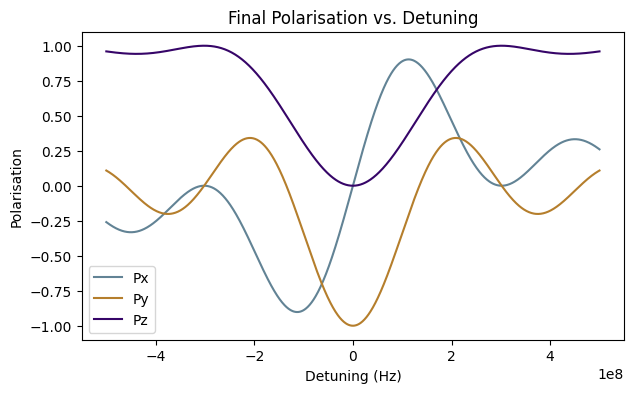

In [27]:
psi0 = up
g = 1.8

w1 = np.genfromtxt('Xpi2_200.csv', delimiter=',')
f_rabi_max = np.max(w1)/(2*np.pi)
b1_max = f_rabi_max*2*np.pi*2*hbar/(g*muB)
tau2 = 1/f_rabi_max *1/4
gamma = g*muB/hbar
b1 = 2*w1/gamma  

print(f'Max rabi = {round(f_rabi_max/1e6, 3)}MHz')
print(f'Min Pi/2 time = {round(tau2/1e-9,3)}ns')
print(f'b1 amp = {round(b1_max, 3)}T')

tau = 200e-9
Np = 200 # Number of samples in pulse
det = np.linspace(-100e6, 100e6, 1000)
det2 = np.linspace(-500e6, 500e6, 1000)
# sim.simulateBlochSphere(psi0, b1, g, tau, 0)
sim.polarisationSpectrum(psi0, b1, g, tau, det2)
sim.polarisationSpectrum(psi0, b1_max, g, tau2, det2)
# sim.projectionSpectrum(psi0, b1, g, tau, det, proj=up)
plt.show()

## Quantum Gate Fidelity
The fidelity of some quantum operation $\mathcal{E}$ (given in operator sum representation) which is designed to implement some desired unitary $U$ can evaluated through the average gate fidelity:
$$
\bar{F}(\Epsilon, U) = \int \langle \psi | U^\dag \mathcal{E} (|\psi\rangle\langle \psi |) U | \psi \rangle d\psi
$$

where $d\psi$ is the uniform (Haar) measure on the Hilbert space of the system. Note that the operator sum representation is a formalism used to denote the final state of a density $\rho$ matrix after some operation: $\rho' = \mathcal{E}(\rho) $. In the case of a closed system, the state $\rho'$ after application of the unitary $\tilde{U}$ is given by: $\mathcal{E} = \tilde{U}\rho\tilde{U}^\dag$.

The above equation for average gate fidelity can be simplified in the case of a single qubit to read:
$$
\bar{F}(\Epsilon, U) = \frac{1}{2} + \frac{1}{12}\sum_{k = \{ 1, 2, 3 \}}\text{Tr}\left( U\sigma_k U^\dag \mathcal{E}(\sigma_k) \right)
$$
where $\sigma_k$ are the pauli matrices. 

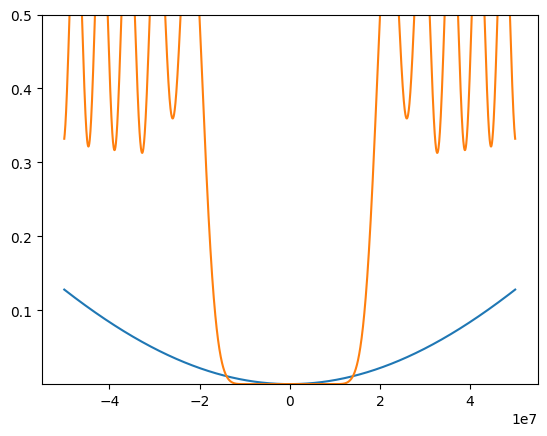

In [32]:
sigmax = np.array([[0, 1], 
                   [1, 0]])
sigmay = np.array([[0, -1.0j], 
                   [1.0j, 0]])
sigmaz = np.array([[1, 0], 
                   [0, -1]])

# Example params for X/2 gate
tau = 200e-9
f_rabi = 1/(4*tau)
b1_square = f_rabi*2*np.pi*2*hbar/(g*muB)
b1_square = b1_max
tau_square = tau2

U_desired = np.array([[1, -1.0j], 
                      [-1.0j, 1]]) * 1/np.sqrt(2)

def average_fidelity(U_desired, U_gate):
    F = 1/2
    sigma_list = [sigmax, sigmay, sigmaz]
    for k in range(3):
        m1 = np.matmul(U_desired,  np.matmul(sigma_list[k], np.conj(U_desired.T))) 
        m2 = np.matmul(U_gate, np.matmul(sigma_list[k], np.conj(U_gate.T)))
        F += 1/12 * np.trace(np.matmul(m1, m2))
    return np.real(F)

detunings = np.linspace(-50e6, 50e6, 2001)
square_infidelities = np.zeros(len(detunings))
for d in range(len(detunings)):
    U_gate = sim.hardPulsePropagator(b1_square, g, tau_square, detunings[d])
    square_infidelities[d] = 1 - average_fidelity(U_desired, U_gate)

# Shaped pulse infidelities
w1 = np.genfromtxt('Xpi2_200.csv', delimiter=',')
gamma = g*muB/hbar
b1_shaped = 2*w1/gamma
tau = 200e-9
Np = 200

def overallUnitary(b1, tau, Np, det):
    dt = tau/Np
    U_gate = np.eye(2)
    for i in range(len(b1)):
        U_i = sim.althardPulsePropagator(b1[i], g, dt, det)
        U_gate = np.matmul(U_i, U_gate)

    return U_gate

shaped_infidelities = np.zeros(len(detunings))
for d in range(len(detunings)):
    U_gate = overallUnitary(b1_shaped, tau, Np, detunings[d])
    shaped_infidelities[d] = 1 - average_fidelity(U_desired, U_gate)

plt.plot(detunings, square_infidelities)
plt.plot(detunings, shaped_infidelities)
# plt.yscale('log')
plt.ylim([10e-9, 50e-2])
# plt.xlim([-2e7, 2e7])
plt.show()